In [1]:
import jax
from jax.config import config
config.update("jax_enable_x64", True)
from jax.tree_util import tree_map

import dLux as dl
from matplotlib import colors, cm, pyplot as plt
import jax.numpy as np
from jax.scipy.special import bessel_jn
from jax import custom_jvp, pure_callback, vmap, grad, jit

from scipy.special import jv

import webbpsf
import poppy
import pysiaf
import scipy
from astropy.io import fits
import astropy.units as u
from tqdm.notebook import tqdm
from dLux.optics import OpticalLayer
from dLux.detectors import DetectorLayer

from nircam_functions import *

Array = np.ndarray

In [2]:
from webb_dlux import get_nircam_optics

In [55]:
plt.figure()
plt.rcParams['image.cmap'] = 'inferno'
plt.rcParams["text.usetex"] = 'true'
plt.rcParams["font.family"] = "serif"
plt.rcParams['figure.dpi'] = 120

<Figure size 768x576 with 0 Axes>

In [60]:
source_offset_x = 0.1 * np.pi / 648000
source_offset_y = 0.0 * np.pi / 648000

In [61]:
def get_osys(instrument, filtr, pup_mask, crn_mask, detector, aperture):
    webb_osys = getattr(webbpsf, instrument)()
    webb_osys.filter = filtr
    webb_osys.pupil_mask = pup_mask
    webb_osys.image_mask = crn_mask
    webb_osys.detector = detector

    # Siaf aperture
    aper = pysiaf.Siaf(instrument)[aperture]
    webb_osys.set_position_from_aperture_name(aperture)
    
    return webb_osys

In [62]:
def get_nircam(source_offset_x = 0, source_offset_y = 0):
    webb_osys = get_osys("NIRCam", "F300M", "CIRCLYOT", "MASK430R", "NRCA5", "NRCA5_FULL_MASK430R") #same as nc.
    webb_osys.options['jitter'] = None   # jitter model name or None
    webb_osys.options['jitter_sigma'] = 0.000  # in arcsec per axis, default 0.007
    webb_osys.options['add_distortion'] = False
    
    source_offset_r = np.sqrt(source_offset_x**2+ source_offset_y**2)
    source_offset_theta = np.arctan2(source_offset_y, source_offset_x)*180/np.pi
    
    #print(source_offset_r)
    #print(source_offset_theta)
    
    #print(source_offset_r * np.sin(source_offset_theta/180*np.pi))
    #print(source_offset_r * np.cos(source_offset_theta/180*np.pi))
    
    webb_osys.options['source_offset_r'] = source_offset_r
    webb_osys.options['source_offset_theta'] = source_offset_theta

    webb_osys.filter='F300M'
    webb_osys.image_mask='MASK430R'
    webb_osys.pupil_mask='CIRCLYOT'
    
    return webb_osys

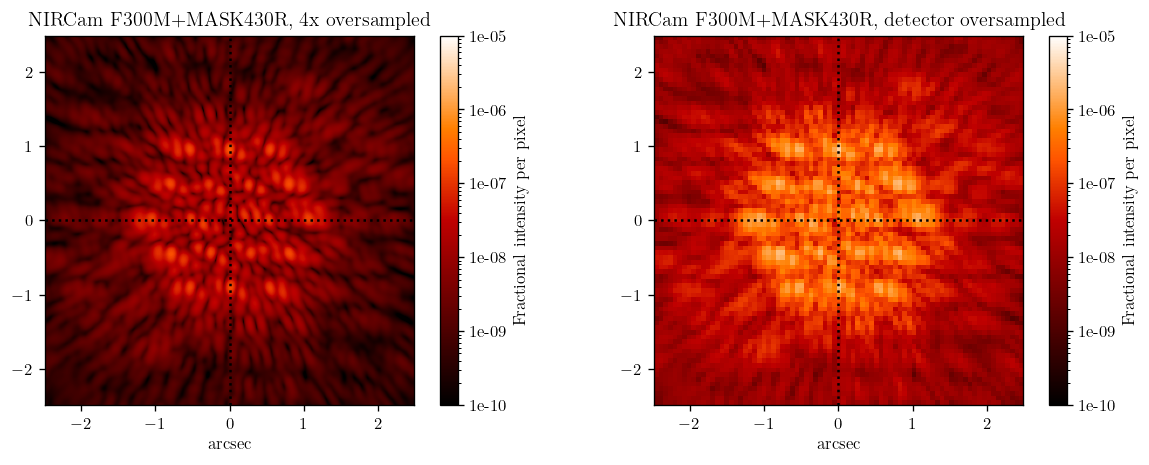

In [59]:
webb_osys = get_nircam()

webb_osys.calc_psf('coronagraphic.fits', oversample=4) #, monochromatic=3.0e-6)   # create highly oversampled output image

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
webbpsf.display_psf('coronagraphic.fits', vmin=1e-10, vmax=1e-5,
    ext='OVERSAMP', title='NIRCam F300M+MASK430R, 4x oversampled', crosshairs=True)
plt.subplot(1,2,2)
webbpsf.display_psf('coronagraphic.fits', vmin=1e-10, vmax=1e-5,
    ext='DET_SAMP', title='NIRCam F300M+MASK430R, detector oversampled', crosshairs=True)

#plt.savefig('example_nircam_coron_resampling.png')

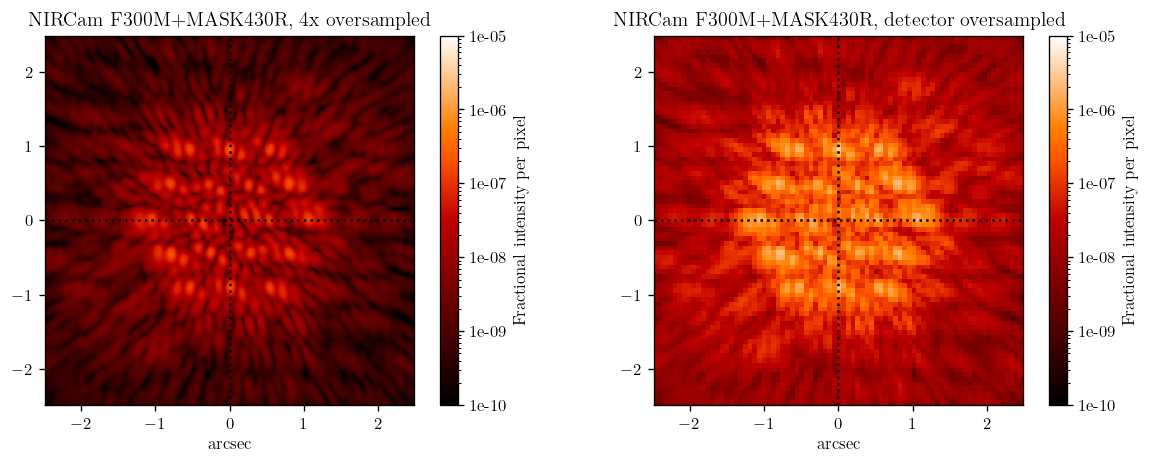

In [63]:
webb_osys = get_nircam(source_offset_x, source_offset_y)

webb_osys.calc_psf('coronagraphic_planet.fits', oversample=4) #, monochromatic=3.0e-6)   # create highly oversampled output image

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
webbpsf.display_psf('coronagraphic_planet.fits', vmin=1e-10, vmax=1e-5,
    ext='OVERSAMP', title='NIRCam F300M+MASK430R, 4x oversampled', crosshairs=True)
plt.subplot(1,2,2)
webbpsf.display_psf('coronagraphic_planet.fits', vmin=1e-10, vmax=1e-5,
    ext='DET_SAMP', title='NIRCam F300M+MASK430R, detector oversampled', crosshairs=True)

#plt.savefig('example_nircam_coron_resampling.png')

In [38]:
# webb_osys.calc_psf?

In [75]:
from astropy.io import fits

hdul = fits.open('coronagraphic.fits')
hdul.info()

webbpsf_header = hdul[0].header
webbpsf_data_star = hdul[0].data

hdul.close()

Filename: coronagraphic.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     123   (316, 316)   float64   
  1  DET_SAMP      1 ImageHDU       124   (79, 79)   float64   
  2  OVERDIST      1 ImageHDU       168   (316, 316)   float64   
  3  DET_DIST      1 ImageHDU       169   (79, 79)   float64   


In [76]:
hdul_planet = fits.open('coronagraphic_planet.fits')
hdul_planet.info()

webbpsf_data_planet = hdul_planet[0].data

hdul_planet.close()

Filename: coronagraphic_planet.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     124   (316, 316)   float64   
  1  DET_SAMP      1 ImageHDU       125   (79, 79)   float64   
  2  OVERDIST      1 ImageHDU       169   (316, 316)   float64   
  3  DET_DIST      1 ImageHDU       170   (79, 79)   float64   


In [77]:
webbpsf_data = webbpsf_data_star + webbpsf_data_planet/100.

In [40]:
webbpsf_header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  316                                                  
NAXIS2  =                  316                                                  
EXTEND  =                    T                                                  
PLANE1  = 'Wavefront Intensity'                                                 
WAVELEN = 2.98203115618662E-06 / Weighted mean wavelength in meters             
DIFFLMT =  0.08833256135803114 / Diffraction limit lambda/D in arcsec           
OVERSAMP=                    4 / Oversampling factor for FFTs in computation    
DET_SAMP=                    4 / Oversampling factor for MFT to detector plane  
PIXELSCL=              0.01575 / Scale in arcsec/pix (after oversampling)       
FOV     =                4.9

[<webbpsf.opds.OTE_Linear_Model_WSS object at 0x7fc3a8b1c7c0>, <poppy.poppy_core.CoordinateInversion object at 0x7fc44ca64970>, <webbpsf.optics.NIRCam_BandLimitedCoron object at 0x7fc44c9cb4c0>, <poppy.poppy_core.FITSOpticalElement object at 0x7fc44c9ca4d0>, <webbpsf.optics.NIRCamFieldAndWavelengthDependentAberration object at 0x7fc44ca647f0>, <poppy.poppy_core.Detector object at 0x7fc44c9cb8b0>]
Plane 0: Pupil plane: JWST Entrance Pupil 



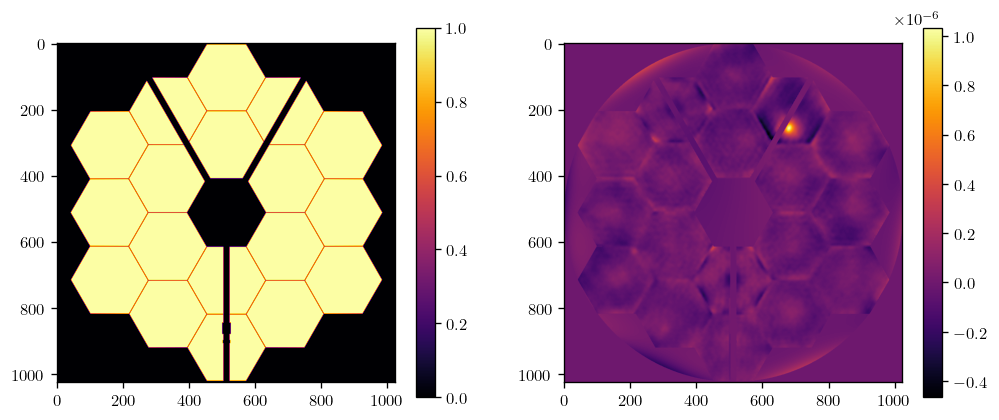

Plane 1: Coordinate Inversion in y axis

Plane 2: Image plane: MASK430R



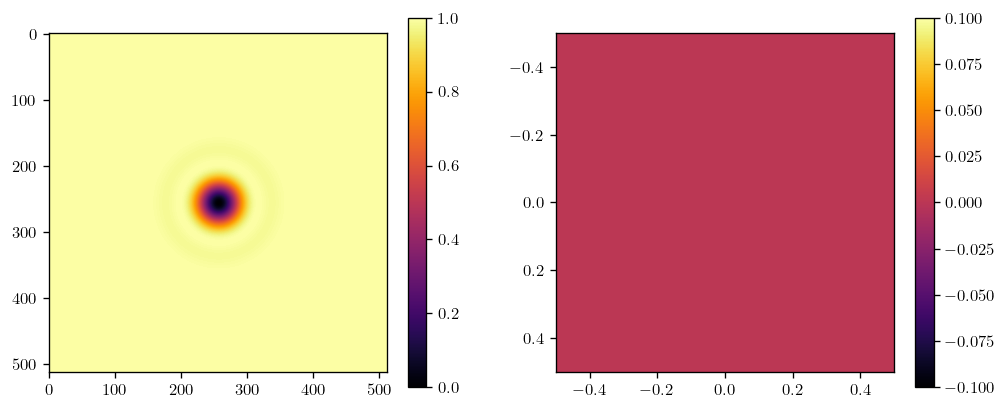

Plane 3: Pupil plane: CIRCLYOT 



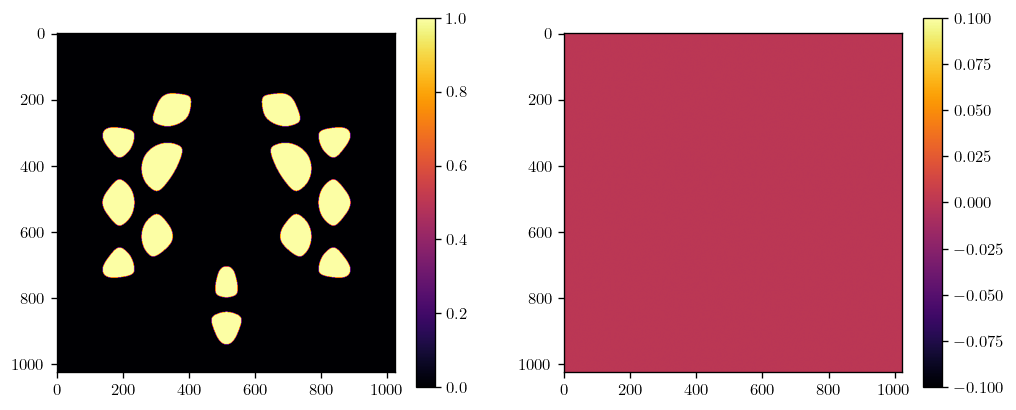

Plane 4: Pupil plane: NIRCamLWA internal WFE at V2V3=(1.46,-6.75)', near Z430R_A 



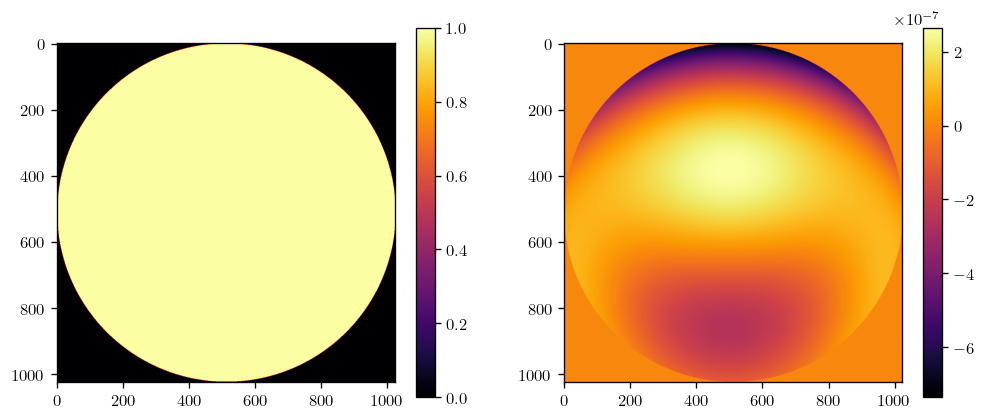

Plane 5: Detector plane: NIRCam detector (79x79 pixels, 0.063 arcsec / pix)



In [41]:
import numpy as onp
#planes = webb_osys.get_optical_system().planes
planes = webb_osys.optsys.planes

phasors = []
opds = []
ampls = []
i = 0

print(planes)

for p in planes:
    print("Plane {}: {}\n".format(i, p))
    
    #print(vars(p))
    
    #if hasattr(p, 'amplitude') and hasattr(p, 'opd'):
    #    if isinstance(p.opd, onp.ndarray) and p.opd.ndim == 2:
    
    if hasattr(p, 'opd') and \
        not isinstance(p.opd, int) and \
            len(p.opd.shape) == 2:

        plt.figure(figsize=(10, 4))
        plt.subplot(1, 2, 1)
        plt.imshow(p.amplitude)
        plt.colorbar()

        plt.subplot(1, 2, 2)
        plt.imshow(p.opd)
        plt.colorbar()
        plt.show()
        
    elif hasattr(p, 'transmission'):
        
        transission = p.transmission
        
        c = transission.shape[0]//2
        s = 256
        # print(i, "True")
        plt.figure(figsize=(10, 4))
        plt.subplot(1, 2, 1)
        plt.imshow(transission[c-s:c+s, c-s:c+s])
        plt.colorbar()
        
        plt.subplot(1, 2, 2)
        plt.imshow(np.zeros([1,1]))
        plt.colorbar()
        plt.show()
        
    i = i+1
                                              
# FPX     =             -1.16891 /                                                
# FPY     =            -0.767005 / 

In [42]:
#webb_0_opd = planes[0].opd
#plt.imshow(webb_0_opd)
#plt.colorbar()

In [43]:
#generating source from fits file

head = webbpsf_header
nwavels = head['NWAVES']
wavels, weights = [], []
for i in range(nwavels):
    wavels.append(head['WAVE'+str(i)])
    weights.append(head['WGHT'+str(i)])

spec = dl.ArraySpectrum(wavels, weights)
source = dl.PointSource(spectrum=spec, position=np.array([-source_offset_y / 648000.0 * np.pi, -source_offset_x / 648000.0 * np.pi]))

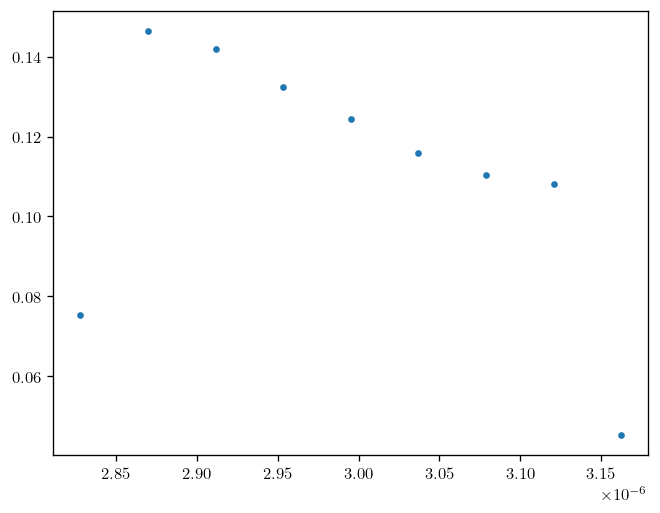

In [44]:
plt.plot(spec.wavelengths,spec.weights,'.')

In [45]:
#webb_osys = get_nircam()
nircam = webb_osys.optsys
pupil_plane = nircam.planes[0]
det_plane = nircam.planes[-1]

In [46]:
pupil_plane.pupil_diam

<Quantity 6.603464 m>

206264.80624709636


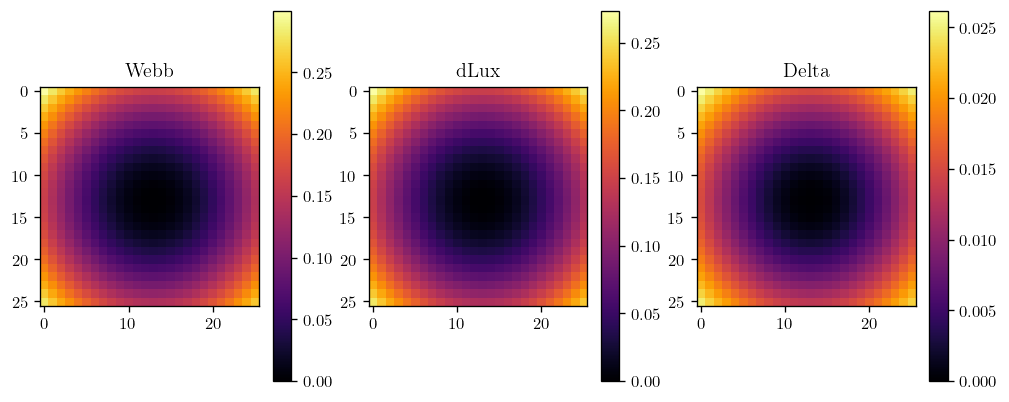

In [47]:
circ = NircamCirc(nircam.planes[2].sigma, nircam.planes[0].pupil_diam.value, 1024, nircam.planes[2].oversample)
#circ_tran = circ.get_transmission(3.0e-6, 0.023426886961952435)
circ_tran = circ.get_transmission(3.0e-6, 1.1357675304961154e-07)

#1.1357675304961154e-07
#0.023426886961952435
#0.02342688696195244 ! Pixelscale differs for same wavelength!

print (648000.0 / np.pi)

plt.figure(figsize=(10, 4))

s = 2035

plt.subplot(1, 3, 1)
plt.title("Webb")
plt.imshow(nircam.planes[2].transmission[s:-s,s:-s])
bar1 = plt.colorbar()

plt.subplot(1, 3, 2)
plt.title("dLux")
plt.imshow(circ_tran[s:-s,s:-s])
bar2 = plt.colorbar()
#bar2.set_ticks(ticks)
#bar2.set_ticklabels(ticks)


plt.subplot(1, 3, 3)
plt.title("Delta")
plt.imshow(np.sqrt((nircam.planes[2].transmission - circ_tran)**2)[s:-s,s:-s])
bar2 = plt.colorbar()

#[0.27325104923515664, 0.25543515017152985, 0.23872784494805788, 0.22320423614232765, 0.2089346258408662, 0.19598406774035593, 0.18441195071565553, 0.17427161705787464, 0.16561001832818023, 0.15846741148995225, 0.1528770976757261, 0.1488652056186902, 0.14645052143417425, 0.1456443660775274, ...]
#[0.27325104923515664, 0.25543515017152985, 0.2387278449480582, 0.22320423614232743, 0.20893462584086642, 0.19598406774035593, 0.18441195071565553, 0.17427161705787486, 0.16561001832818023, 0.15846741148995225, 0.1528770976757261, 0.14886520561869043, 0.14645052143417447, 0.1456443660775274, 0.14645052143417447, 0.14886520561869043, 0.1528770976757261, 0.15846741148995225, 0.16561001832818023, 0.17427161705787486, 0.18441195071565553, 0.19598406774035593, 0.20893462584086642, 0.22320423614232743, 0.2387278449480582, 0.25543515017152985

In [48]:
# Wavefront 
npix = 1024
diameter = pupil_plane.pixelscale.to('m/pix').value * pupil_plane.npix
# diameter == 6.603464

# Aperture and OPD
webb_aper = nircam.planes[0].amplitude
webb_opd = nircam.planes[0].opd
pupil_mask = nircam.planes[3].amplitude

# Detector
det_npix = (det_plane.fov_pixels * det_plane.oversample).value
print(det_npix)
pscale = det_plane.pixelscale/det_plane.oversample
print(pscale)
pscale = pscale.to('radian/pix').value

# pscale == 7.958548e-08

# Make layers

def get_optical_layers():
    optical_layers = [
        #Plane 0: Pupil plane: JWST Entrance Pupil
        dl.CreateWavefront(npix, diameter, 'Angular'),
        dl.TransmissiveOptic(webb_aper),
        #dl.OPD(npix=1024, opd_array=f64[1024,1024]),
        dl.AddOPD(webb_opd),

        #Plane 1: Coordinate Inversion in y axis
        InvertY(),

        #Plane 2: Image plane: MASK430R
        Pad(npix * nircam.planes[2].oversample),
        dl.AngularFFT(),
        #TODO: Call get_transmission(wavefront)
        #dl.TransmissiveOptic(nircam.planes[2].transmission),
        NircamCirc(nircam.planes[2].sigma, diameter, npix, nircam.planes[2].oversample),
        dl.AngularFFT(inverse=True),
        Crop(npix),

        #Plane 3: Pupil plane: CIRCLYOT
        dl.TransmissiveOptic(pupil_mask),

        #Plane 4: Pupil plane: NIRCamLWA internal WFE at V2V3=(1.46,-6.75)', near Z430R_A
        #dl.AddOPD(nircam.planes[4].get_opd(wavel)),
        NIRCamFieldAndWavelengthDependentAberration(webb_osys, nircam.planes[4].opd, nircam.planes[4].zernike_coeffs),

        #Plane 5: Detector plane: NIRCam detector (79x79 pixels, 0.063 arcsec / pix)
        dl.AngularMFT(det_npix, pscale),
        #InvertXY()          
    ]
    return optical_layers

optical_layers = get_optical_layers()

optics = dl.Optics(optical_layers)


316.0
0.01575 arcsec / pix
opd_ref_focus: {} 6.714345736893632e-08
tilt_ref_offset: {} 5.4124063812869335e-08


In [85]:
%%time
print("Modelling optics...")
psf = optics.model(source=source)
print("Modelling optics...ok")
psf_norm = psf/psf.sum()
webbpsf_norm = webbpsf_data/webbpsf_data.sum()

norm = colors.LogNorm(vmin=1e-10, vmax=1e-5)
vmin = 1e-10
vmax = 1e-5
ticks = np.logspace(np.log10(vmin), np.log10(vmax), int(np.round(np.log10(vmax / vmin) + 1)))


Modelling optics...
Modelling optics...ok
CPU times: user 1min 5s, sys: 1min 14s, total: 2min 19s
Wall time: 1min 9s


In [86]:
@jit
def test():
    return optics.model(source=source)

test()

2023-04-05 17:30:39.277832: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:65] Constant folding an instruction is taking > 1s:

  dynamic-update-slice.10 (displaying the full instruction incurs a runtime overhead. Raise your logging level to 4 or above).

This isn't necessarily a bug; constant-folding is inherently a trade-off between compilation time and speed at runtime.  XLA has some guards that attempt to keep constant folding from taking too long, but fundamentally you'll always be able to come up with an input program that takes a long time.

If you'd like to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
2023-04-05 17:30:39.432440: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:133] The operation took 1.159742s
Constant folding an instruction is taking > 1s:

  dynamic-update-slice.10 (displaying the full instruction incurs a runtime overhead. Raise your logging level to 4

DeviceArray([[2.77218778e-09, 2.70698406e-09, 2.74350413e-09, ...,
              1.86875486e-09, 1.98417564e-09, 2.14015677e-09],
             [2.84384644e-09, 2.70755471e-09, 2.68926891e-09, ...,
              2.16100823e-09, 2.24471328e-09, 2.36765487e-09],
             [3.09011795e-09, 2.84042467e-09, 2.72048103e-09, ...,
              2.46294248e-09, 2.50562594e-09, 2.58700798e-09],
             ...,
             [2.91800933e-09, 2.93499688e-09, 3.03509777e-09, ...,
              1.12683021e-08, 1.18057457e-08, 1.24864055e-08],
             [3.35769936e-09, 3.30990309e-09, 3.28779118e-09, ...,
              9.25708770e-09, 9.80920002e-09, 1.05655127e-08],
             [3.58807275e-09, 3.41430401e-09, 3.23132180e-09, ...,
              7.29835277e-09, 7.79452193e-09, 8.53850392e-09]],            dtype=float64)

In [90]:
%%time 

test()

CPU times: user 50.8 s, sys: 2.2 s, total: 53 s
Wall time: 17.9 s


DeviceArray([[2.77218778e-09, 2.70698406e-09, 2.74350413e-09, ...,
              1.86875486e-09, 1.98417564e-09, 2.14015677e-09],
             [2.84384644e-09, 2.70755471e-09, 2.68926891e-09, ...,
              2.16100823e-09, 2.24471328e-09, 2.36765487e-09],
             [3.09011795e-09, 2.84042467e-09, 2.72048103e-09, ...,
              2.46294248e-09, 2.50562594e-09, 2.58700798e-09],
             ...,
             [2.91800933e-09, 2.93499688e-09, 3.03509777e-09, ...,
              1.12683021e-08, 1.18057457e-08, 1.24864055e-08],
             [3.35769936e-09, 3.30990309e-09, 3.28779118e-09, ...,
              9.25708770e-09, 9.80920002e-09, 1.05655127e-08],
             [3.58807275e-09, 3.41430401e-09, 3.23132180e-09, ...,
              7.29835277e-09, 7.79452193e-09, 8.53850392e-09]],            dtype=float64)

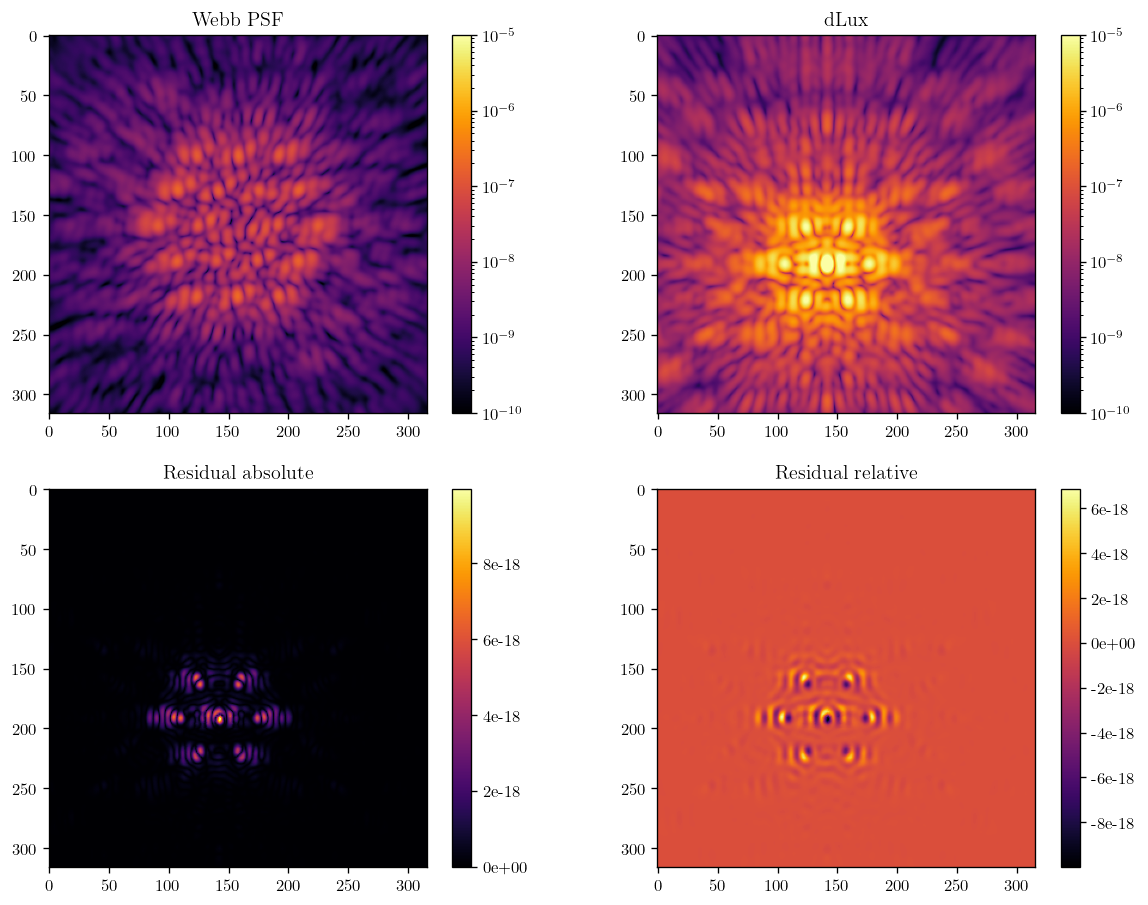

In [69]:
plt.figure(figsize=(12, 9))

plt.subplot(2, 2, 1)
plt.title("Webb PSF")
plt.imshow(webbpsf_data, norm=norm)
bar1 = plt.colorbar()
#bar1.set_ticks(ticks)
#bar1.set_ticklabels(ticks)

plt.subplot(2, 2, 2)
plt.title("dLux")
plt.imshow(psf, norm=norm)
bar2 = plt.colorbar()
#bar2.set_ticks(ticks)
#bar2.set_ticklabels(ticks)

plt.subplot(2, 2, 3)
plt.title("Residual absolute")
plt.imshow(abs(webbpsf_norm - psf_norm))
# plt.imshow(webbpsf_norm/psf_norm)
plt.colorbar(format='%.0e')

plt.subplot(2, 2, 4)
plt.title("Residual relative")
plt.imshow(webbpsf_norm - psf_norm)
# plt.imshow(webbpsf_norm/psf_norm)
plt.colorbar(format='%.0e')

#mse = (np.sqrt((webbpsf_norm - psf_norm)**2)).max()
#print(mse)

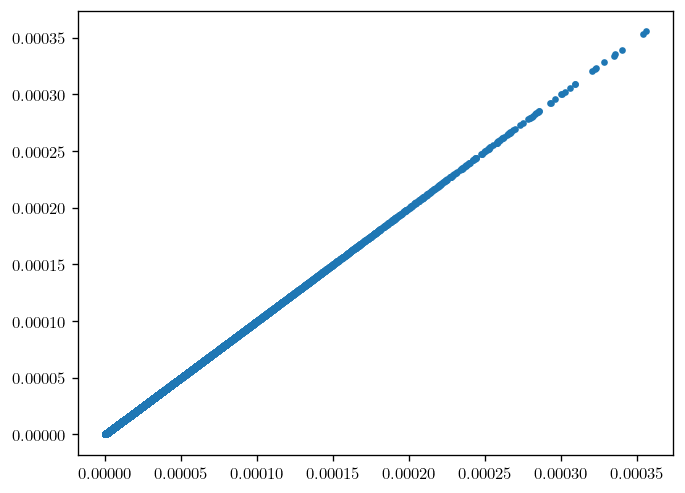

In [23]:
plt.plot(webbpsf_norm.ravel(),psf_norm.ravel(),'.')

In [24]:
webb_osys.pixelscale

0.063

In [59]:
as2rad = np.pi/180/3600.
pscale/as2rad

0.01575

In [60]:

nircam.planes[4].get_opd(3.0e-6).shape

(1024, 1024)

2.219026566007283e-09
2.2190228455247856e-07


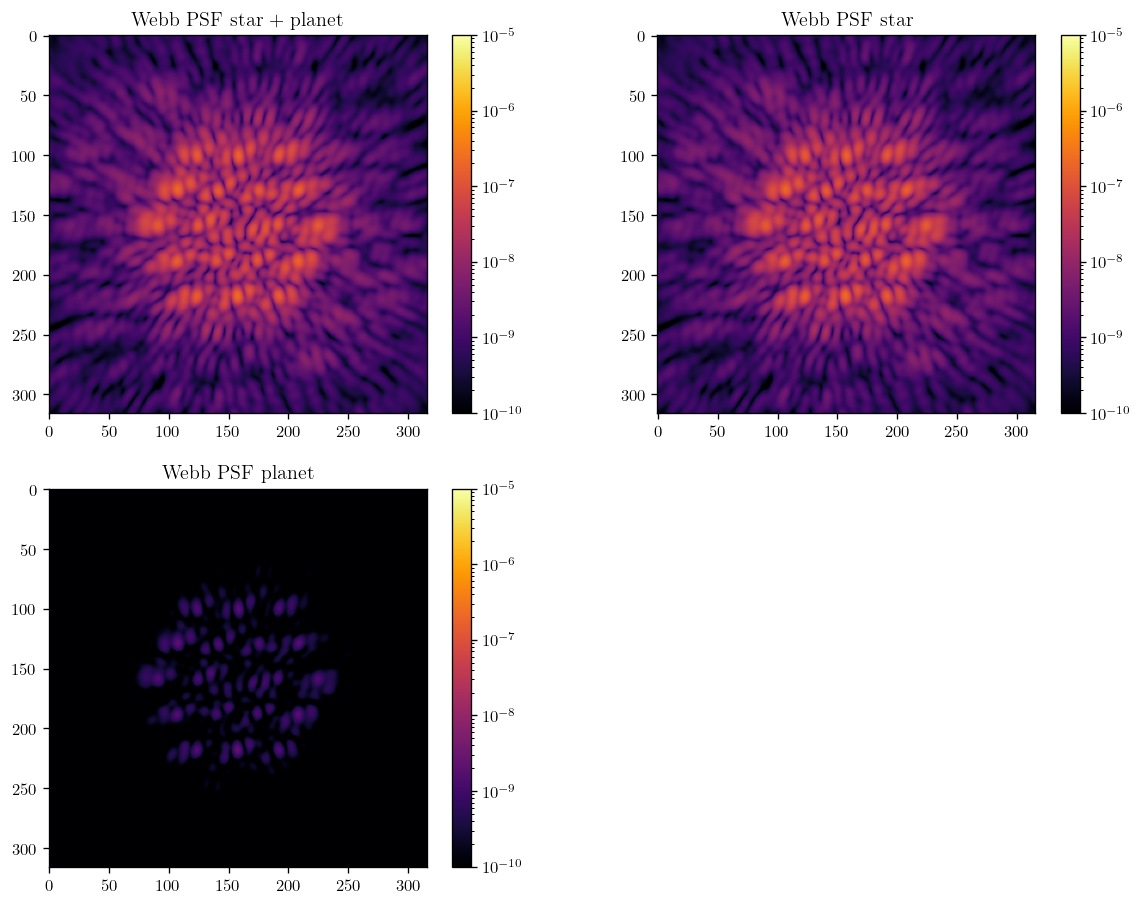

In [84]:
plt.figure(figsize=(12, 9))

plt.subplot(2, 2, 1)
plt.title("Webb PSF star + planet")
plt.imshow(webbpsf_data, norm=norm)
bar1 = plt.colorbar()
#bar1.set_ticks(ticks)
#bar1.set_ticklabels(ticks)

plt.subplot(2, 2, 2)
plt.title("Webb PSF star")
plt.imshow(webbpsf_data_star, norm=norm)
bar1 = plt.colorbar()
#bar1.set_ticks(ticks)
#bar1.set_ticklabels(ticks)

plt.subplot(2, 2, 3)
plt.title("Webb PSF planet")
plt.imshow(webbpsf_data_planet/100, norm=norm)
bar1 = plt.colorbar()
#bar1.set_ticks(ticks)
#bar1.set_ticklabels(ticks)

#plt.subplot(2, 2, 4)
#plt.title("Webb PSF")
#plt.imshow(webbpsf_data - webbpsf_data_star, norm=norm)
#bar1 = plt.colorbar()
#bar1.set_ticks(ticks)
#bar1.set_ticklabels(ticks)

print((webbpsf_data_planet/100).max())
print((webbpsf_data_star).max())